# Adhering to point measurements

This notebook explains one approach to `smallness regularization`, with the goal of adhering to prior knowledge of topography we're aiming to recover. In the scenario of a sediment-basement contact inversion, if we know the basement depth at a few points from drill holes or seismic data, we want the inverted results to adhere to these points, which we refer to as `constraints`. 

We offer 2 methods to adhere to theses points:
1) Using the Constraint Point Minimization technique for regional misfit estimation.
    - this defines the regional field so that the residual field is 0 and constraints, resulting in minimal changing of the topography at constraints during the inversion.
2) Using a weighting grid, which smoothly tapers each iterations topography correction to be 0 at constraint points. 
    
Again, we will use the same synthetic data from the past examples.

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2
import os

import pandas as pd
import verde as vd
from polartoolkit import maps
from polartoolkit import utils as polar_utils

import invert4geom

os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

/home/sungw937/miniforge3/envs/invert4geom/lib/python3.12/site-packages/UQpy/__init__.py:6: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



## Create observed gravity data
To run the inversion, we need to have observed gravity data. In this simple example, we will first create a synthetic topography, which represents the `true` Earth topography which we hope to recover during the inversion. From this topography, we will create a layer of vertical right-rectangular prisms, which allows us to calculated the gravity effect of the topography. This will act as our observed gravity data. 

Sample the starting topography at 10 random locations and regrid with those sampled values. This simulates only knowing the depth to this topography at 10 boreholes.

In [2]:
true_topography, _, _, _ = invert4geom.load_synthetic_model(
    spacing=500,
    region=(0, 40000, 0, 30000),
)

# create lower synthetic topography data
lower_topography = invert4geom.synthetic_topography_regional(
    500,
    (0, 40000, 0, 30000),
    scale=1,
    yoffset=-1000,
)

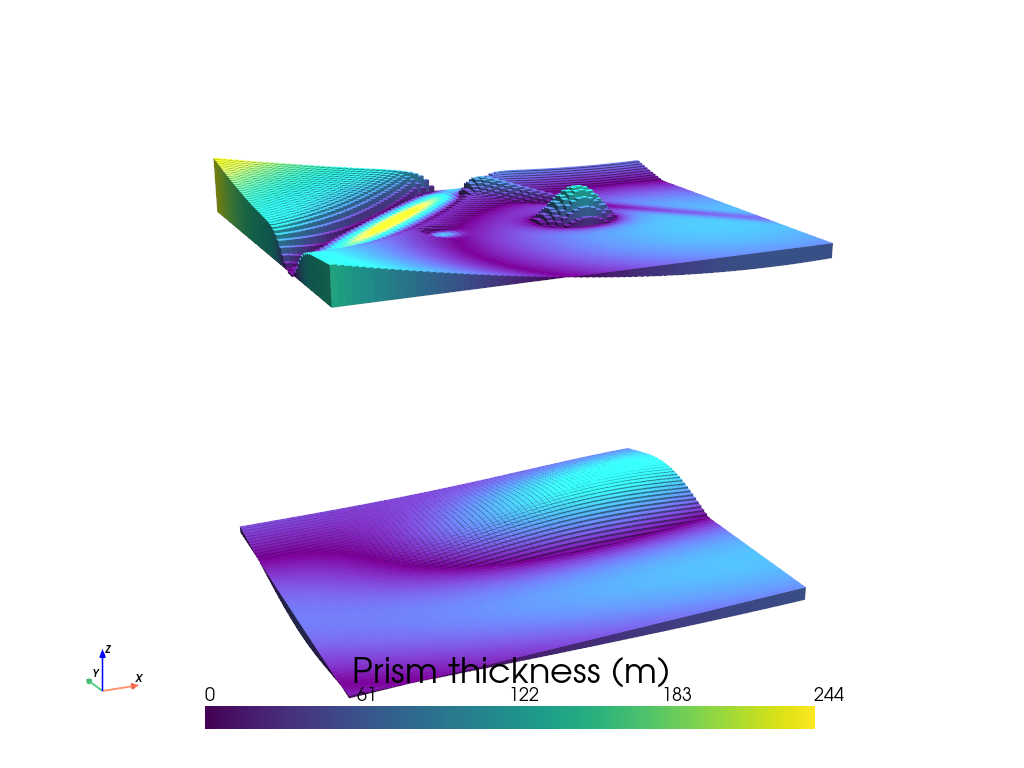

In [ ]:
upper_model = invert4geom.create_model(
    zref=true_topography.to_numpy().mean(),
    density_contrast=2670 - 1,
    topography=true_topography.to_dataset(name="upward"),
)
lower_model = invert4geom.create_model(
    zref=lower_topography.to_numpy().mean(),
    density_contrast=3100 - 2670,
    topography=lower_topography.to_dataset(name="upward"),
)

invert4geom.plot_prism_layers(
    [upper_model, lower_model],
    color_by="thickness",
    zscale=20,
)

In [4]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    spacing=500,
    region=(0, 40000, 0, 30000),
    pixel_register=False,
    extra_coords=1001,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
)

grav_data = invert4geom.create_data(observations)

# forward gravity of upper and lower prisms
grav_data.inv.forward_gravity(upper_model, "upper_surface_grav")
grav_data.inv.forward_gravity(lower_model, "lower_surface_grav")

grav_data["gravity_anomaly"] = (
    grav_data.upper_surface_grav + grav_data.lower_surface_grav
)
grav_data

<xarray.Dataset> Size: 159kB
Dimensions:             (northing: 61, easting: 81)
Coordinates:
  * northing            (northing) float64 488B 0.0 500.0 ... 2.95e+04 3e+04
  * easting             (easting) float64 648B 0.0 500.0 ... 3.95e+04 4e+04
Data variables:
    upward              (northing, easting) float64 40kB 1.001e+03 ... 1.001e+03
    upper_surface_grav  (northing, easting) float64 40kB 6.966 8.536 ... 2.06
    lower_surface_grav  (northing, easting) float64 40kB -0.04507 ... 0.385
    gravity_anomaly     (northing, easting) float64 40kB 6.921 8.486 ... 2.445
Attributes:
    region:        (0.0, 40000.0, 0.0, 30000.0)
    spacing:       500.0
    buffer_width:  3000.0
    inner_region:  (3000.0, 37000.0, 3000.0, 27000.0)
    dataset_type:  data
    model_type:    prisms

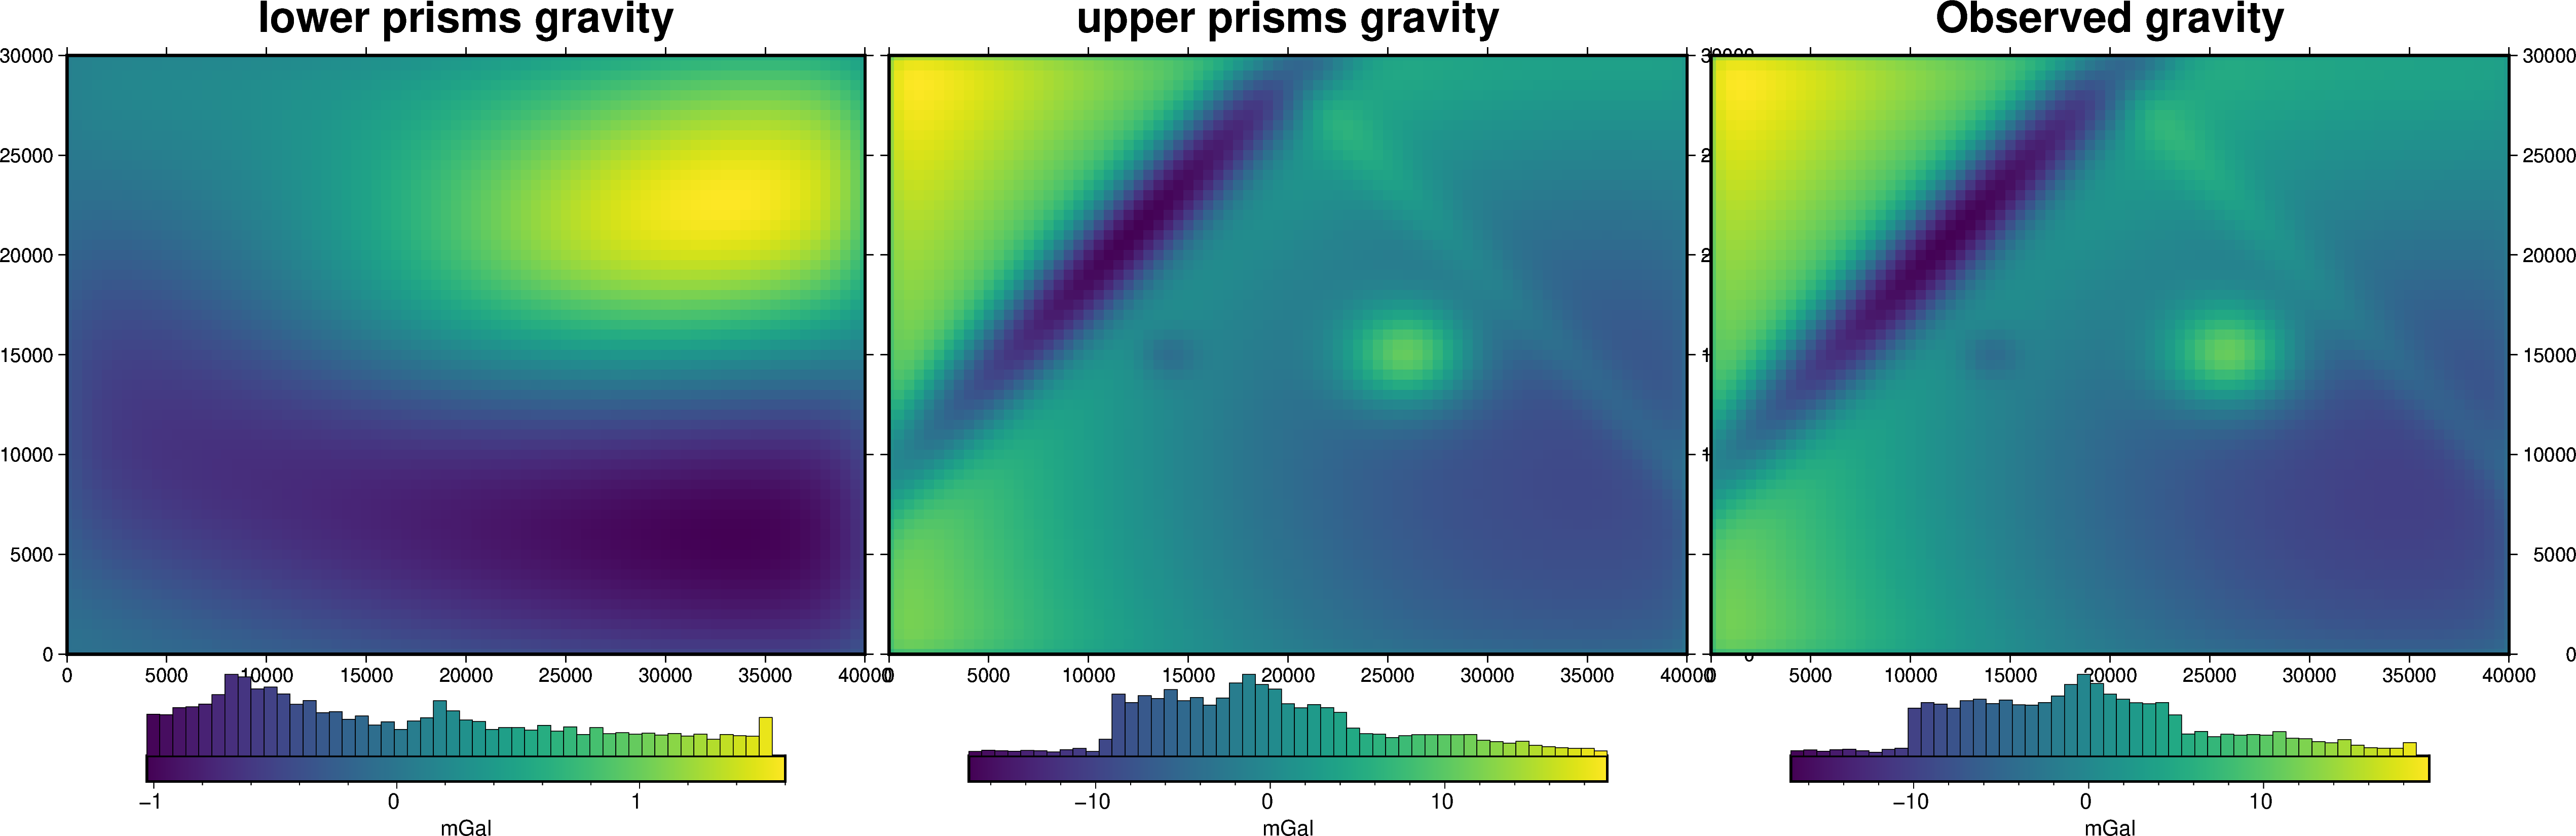

In [5]:
fig = maps.plot_grd(
    grav_data.lower_surface_grav,
    fig_height=10,
    title="lower prisms gravity",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_data.upper_surface_grav,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="upper prisms gravity",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_data.gravity_anomaly,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Observed gravity",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig.show()

## Create "a-priori" topography measurements

In [6]:
# create 25 random point within the outcropping basement region
num_constraints = 25
coords = vd.scatter_points(
    region=vd.pad_region(grav_data.region, -500),
    size=num_constraints,
    random_state=0,
)
constraint_points = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

# sample true topography at these points
constraint_points = invert4geom.sample_grids(
    constraint_points,
    true_topography,
    "upward",
)
constraint_points.head()

,easting,northing,upward
0,21903.726653,19057.709618,472.843511
1,28392.385289,4657.245335,417.654600
2,24007.771667,27895.398594,537.989827
3,21750.444137,15633.601331,485.088965
4,17022.537174,12525.196260,471.304408


## Create starting model

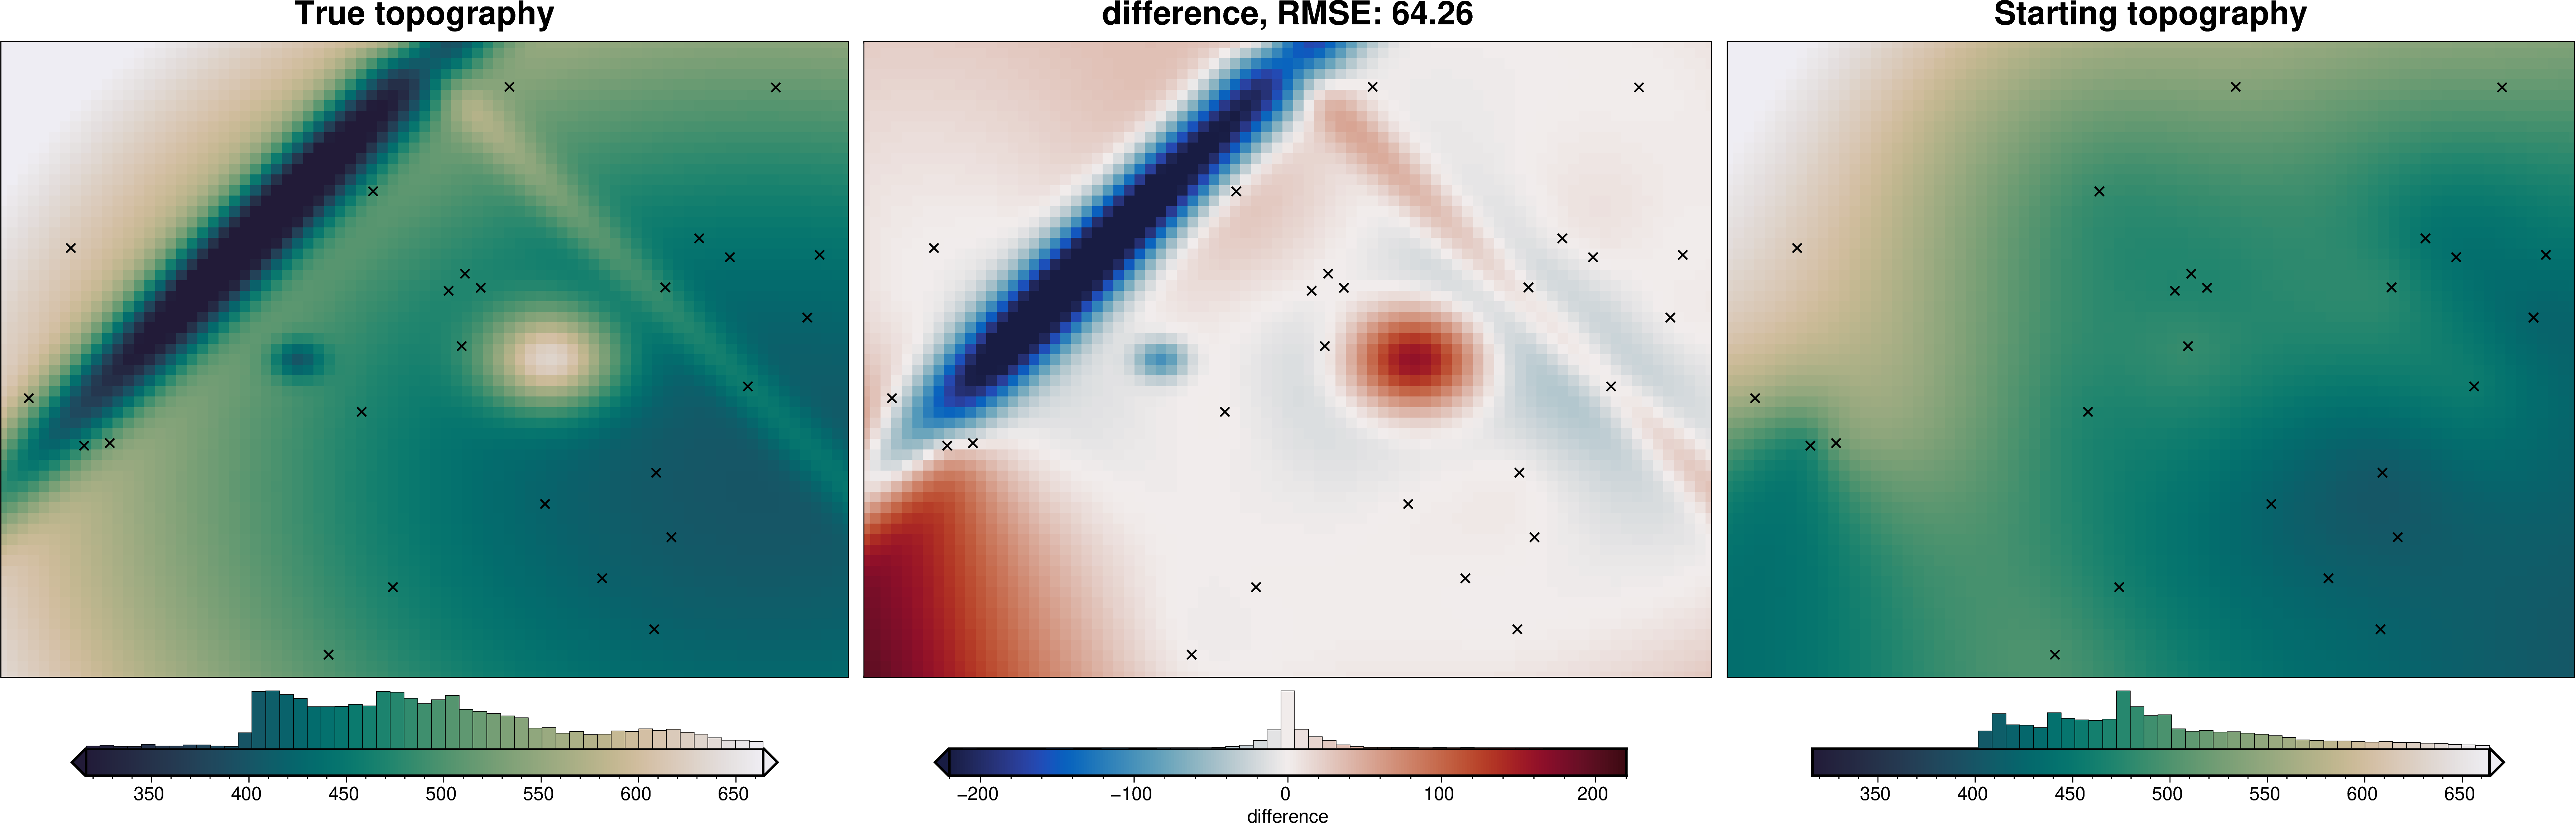

In [ ]:
# grid the sampled values using verde
starting_topography_kwargs = dict(
    method="splines",
    region=grav_data.region,
    spacing=grav_data.spacing,
    constraints_df=constraint_points,
    # dampings=np.logspace(-40, 0, 100),
    dampings=None,
)

starting_topography = invert4geom.create_topography(**starting_topography_kwargs)

_ = polar_utils.grd_compare(
    true_topography,
    starting_topography.upward,
    grid1_name="True topography",
    grid2_name="Starting topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

In [ ]:
# sample the inverted topography at the constraint points
constraint_points = invert4geom.sample_grids(
    constraint_points,
    starting_topography.upward,
    "starting_topography",
)

rmse_starting = invert4geom.rmse(
    constraint_points.upward - constraint_points.starting_topography
)
max_error_starting = vd.maxabs(
    constraint_points.upward - constraint_points.starting_topography
)

print(f"RMSE at constraints: {round(rmse_starting, 1)} m")
print(f"max error at constraints: {round(max_error_starting, 1)} m")

RMSE at constraints: 0.1 m
max error at constraints: 0.5 m


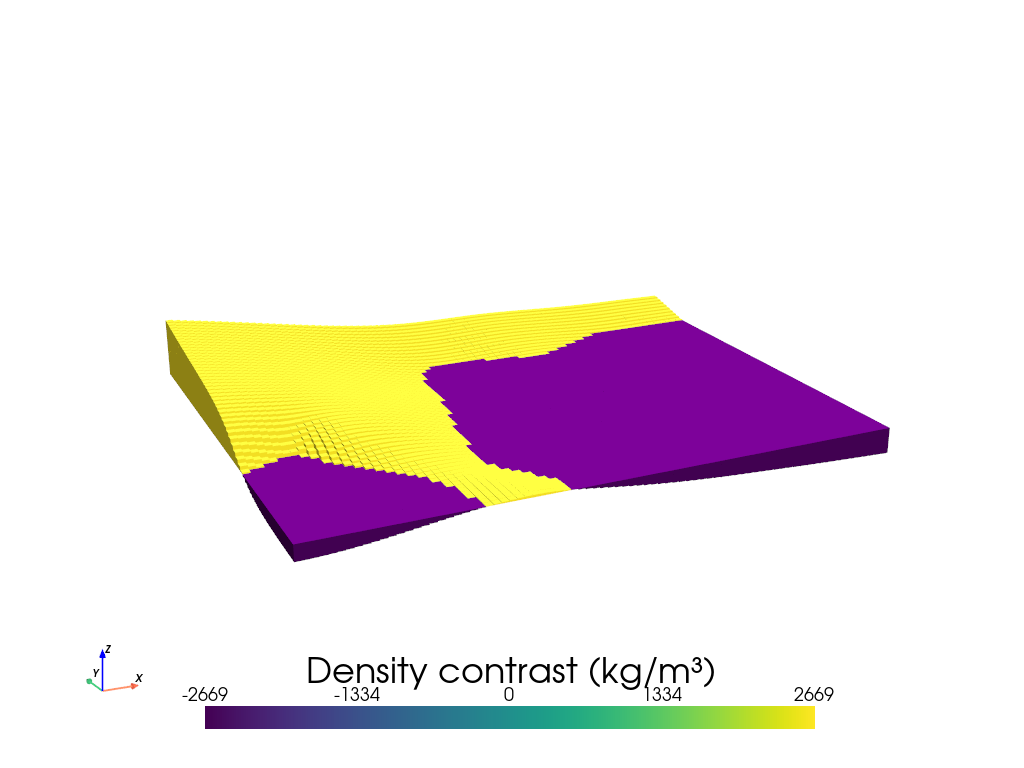

In [ ]:
model = invert4geom.create_model(
    zref=true_topography.to_numpy().mean(),
    density_contrast=2670 - 1,
    topography=starting_topography,
)
model.inv.plot_model(
    color_by="density",
    zscale=20,
)

## Method 1: Weighting grid

To force the inversion to adhere to the starting model we need to supply a weighting grid. At each iteration, the `correction grid` is multiplied by this weighting grid to alter the iteration's correction. Therefore, this weighting grid should be ~0 at the constraints, so that they aren't altered from the starting model. These values should increase to ~1 at a distance to allow the inversion to be un-affected at locations far from constraints. 

### Gravity misfit
Now we need to calculate the forward gravity of the starting topography. We then can subtract it from our observed gravity to get a starting gravity misfit. For this, the regional component will just be constant, the mean of the misfit at the constraint points.

In [18]:
grav_data.inv.forward_gravity(model)

grav_data.inv.regional_separation(
    method="constant",
    constraints_df=constraint_points,
)
grav_data

<xarray.Dataset> Size: 475kB
Dimensions:                   (northing: 61, easting: 81)
Coordinates:
  * northing                  (northing) float64 488B 0.0 500.0 ... 3e+04
  * easting                   (easting) float64 648B 0.0 500.0 ... 4e+04
Data variables:
    upward                    (northing, easting) float64 40kB 1.001e+03 ... ...
    upper_surface_grav        (northing, easting) float64 40kB 6.966 ... 2.06
    lower_surface_grav        (northing, easting) float64 40kB -0.04507 ... 0...
    gravity_anomaly           (northing, easting) float64 40kB 6.921 ... 2.445
    forward_gravity           (northing, easting) float64 40kB -2.37 ... 1.78
    misfit                    (northing, easting) float64 40kB 9.291 ... 0.6649
    reg                       (northing, easting) float64 40kB -0.617 ... -0.617
    res                       (northing, easting) float64 40kB 9.908 ... 1.282
    starting_forward_gravity  (northing, easting) float64 40kB -2.37 ... 1.78
    starting_misfit           (northing, easting) float64 40kB 9.291 ... 0.6649
    starting_reg              (northing, easting) float64 40kB -0.617 ... -0.617
    starting_res              (northing, easting) float64 40kB 9.908 ... 1.282
Attributes:
    region:        (0.0, 40000.0, 0.0, 30000.0)
    spacing:       500.0
    buffer_width:  3000.0
    inner_region:  (3000.0, 37000.0, 3000.0, 27000.0)
    dataset_type:  data
    model_type:    prisms

makecpt [ERROR]: Option T: min >= max
supplied min value is greater or equal to max value
Grid/points are a constant value, can't make a colorbar histogram!


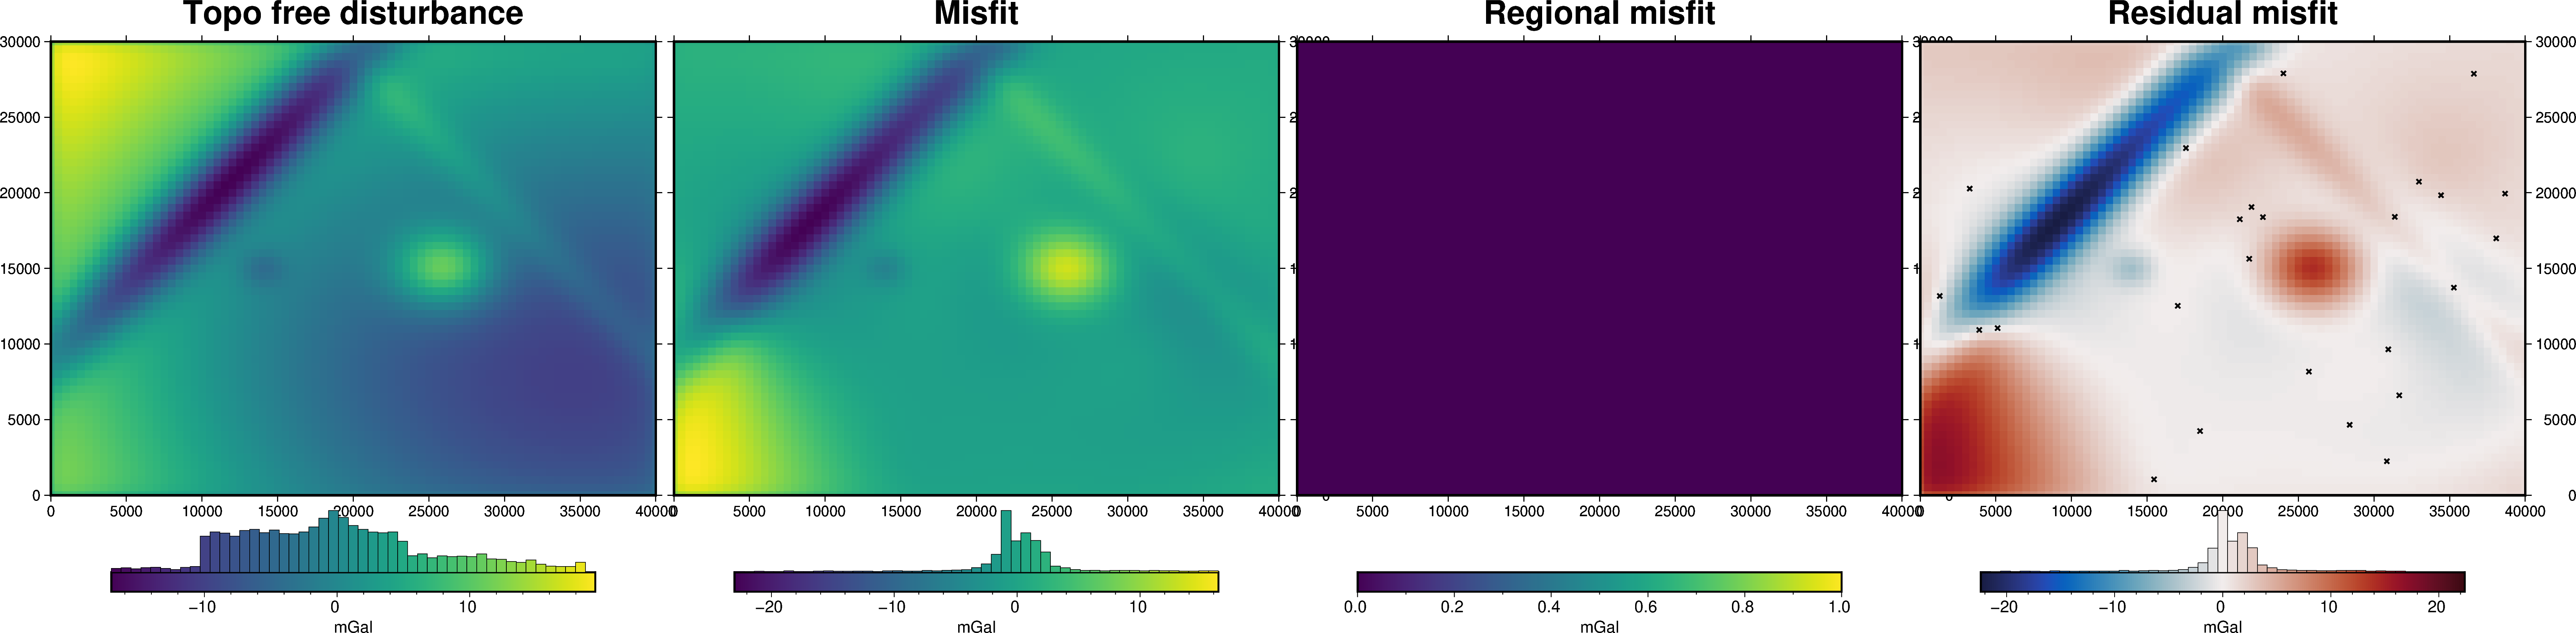

In [19]:
fig = maps.plot_grd(
    grav_data.gravity_anomaly,
    fig_height=10,
    title="Topo free disturbance",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_data.misfit,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Misfit",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_data.reg,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Regional misfit",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_data.res,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Residual misfit",
    cmap="balance+h0",
    cpt_lims=[-vd.maxabs(grav_data.res), vd.maxabs(grav_data.res)],
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
    points=constraint_points,
    points_style="x.15c",
)
fig.show()

### Create weighting grid

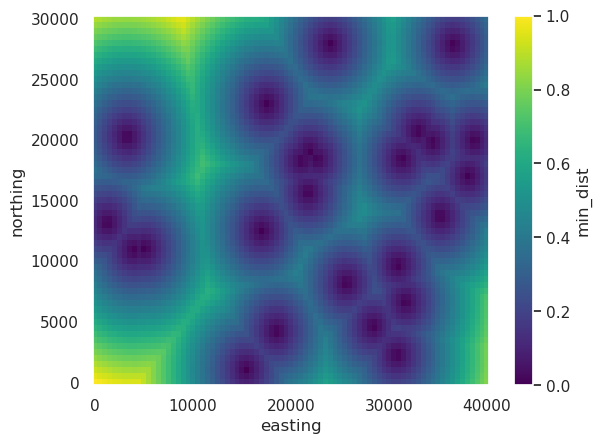

In [20]:
# calculate the distance between each grid cell and the nearest constraint, then
# normalize those values between 0 and 1
weighting_grid = invert4geom.normalized_mindist(
    constraint_points,
    model.starting_topography,
    low=0,
    high=1,
)
weighting_grid.plot()

### Perform inversion
Now we can perform the inversion, supplying the argument `apply_weighting_grid=True` and supplying the grid to argument `weighting_grid`.

In [21]:
# setup the inversion
inv = invert4geom.Inversion(
    grav_data,
    model,
    solver_damping=0.05,
    apply_weighting_grid=True,
    weighting_grid=weighting_grid,
    # set stopping criteria
    max_iterations=300,
    l2_norm_tolerance=0.3,
    delta_l2_norm_tolerance=1.005,
)

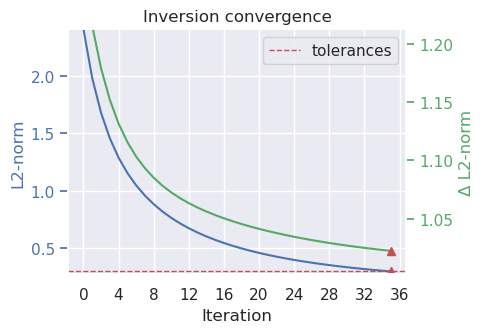

In [22]:
inv.invert(
    plot_dynamic_convergence=True,
    results_fname="../tmp/weighted_inversion",
)

In [23]:
inv.stats_df

,iteration,rmse,l2_norm,delta_l2_norm,iter_time_sec
0,0.0,5.796239,2.407538,inf,NaN
1,1.0,3.920676,1.980070,1.215885,3.294493
2,2.0,2.818514,1.678843,1.179425,3.658995
3,3.0,2.122831,1.456994,1.152265,3.542416
4,4.0,1.657434,1.287414,1.131721,3.587720
5,5.0,1.331127,1.153745,1.115857,3.545207
6,6.0,1.093419,1.045667,1.103358,3.397984
7,7.0,0.914728,0.956414,1.093320,3.690237
8,8.0,0.776861,0.881397,1.085111,3.889203
9,9.0,0.668156,0.817408,1.078283,4.696160


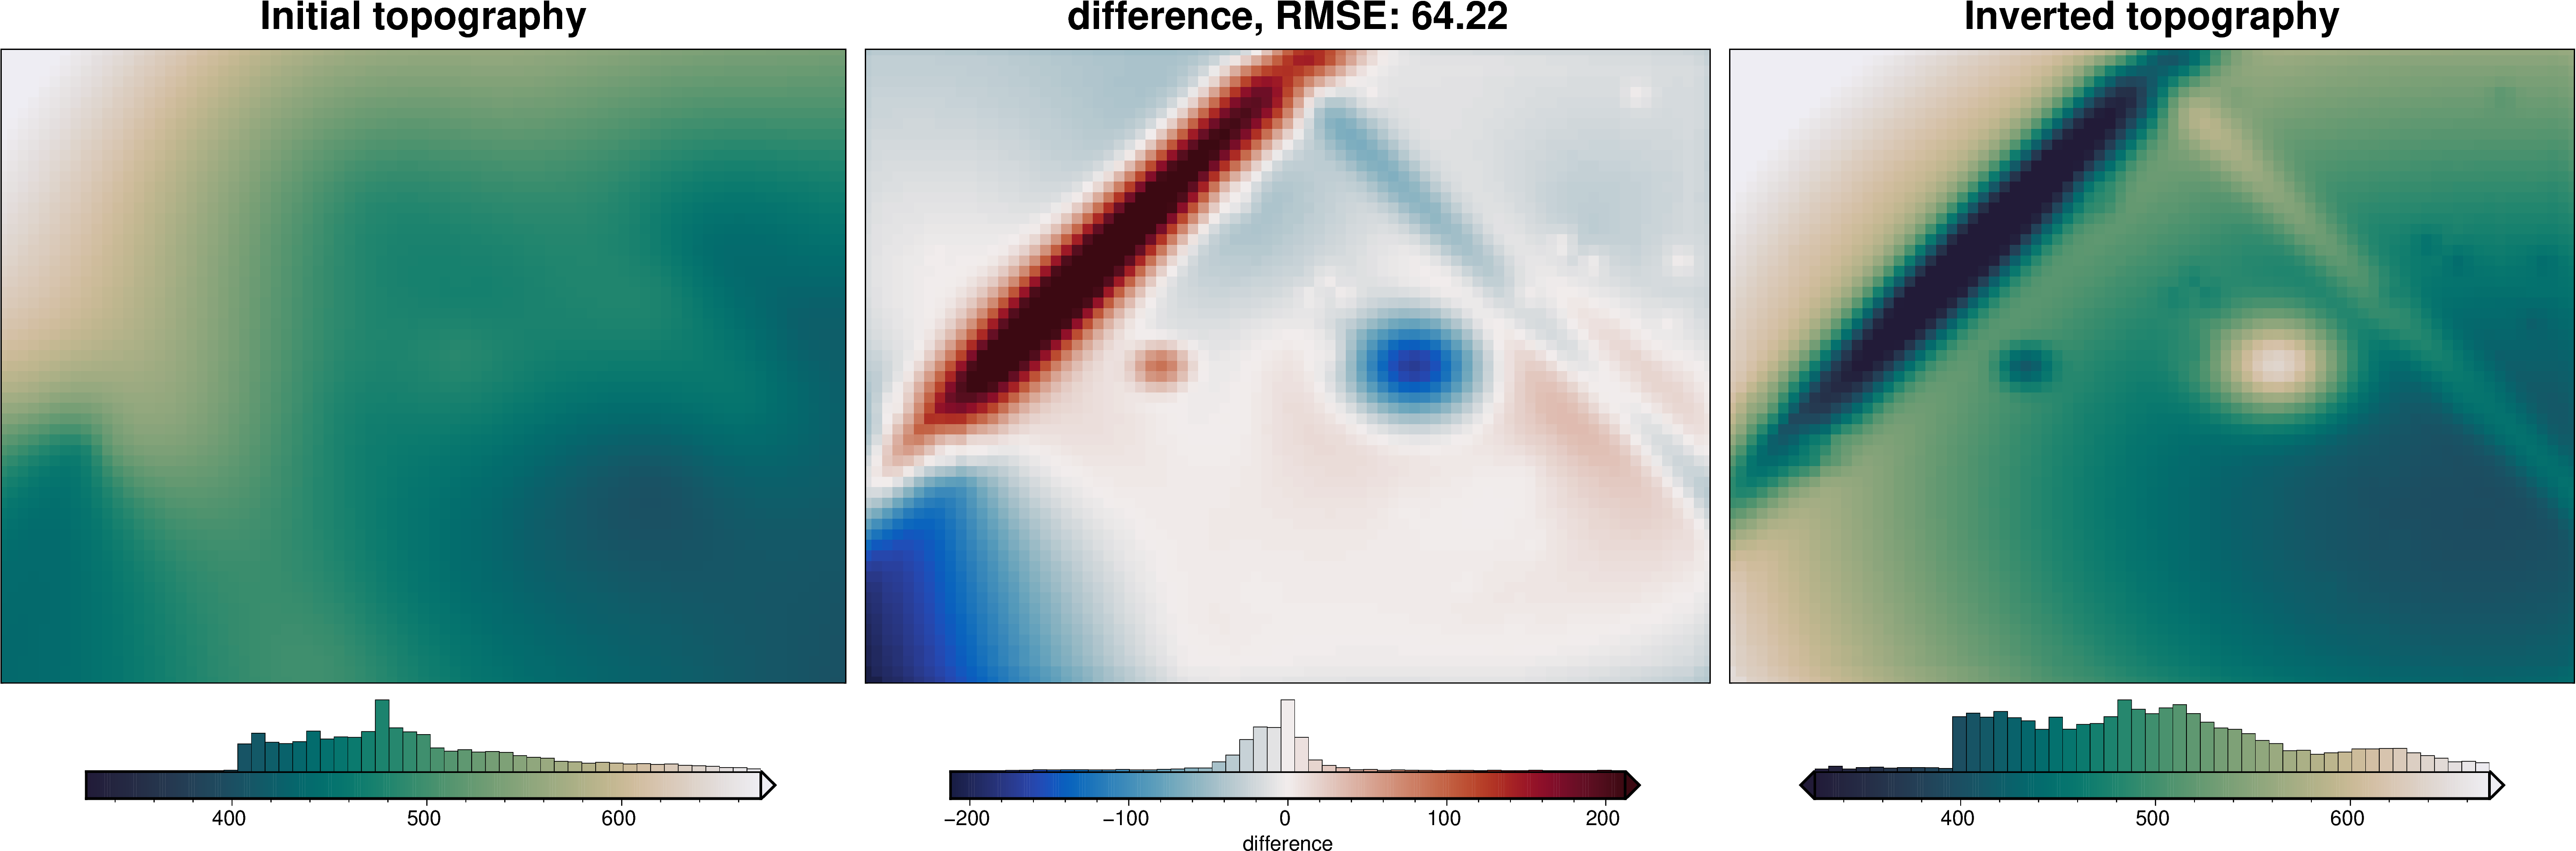

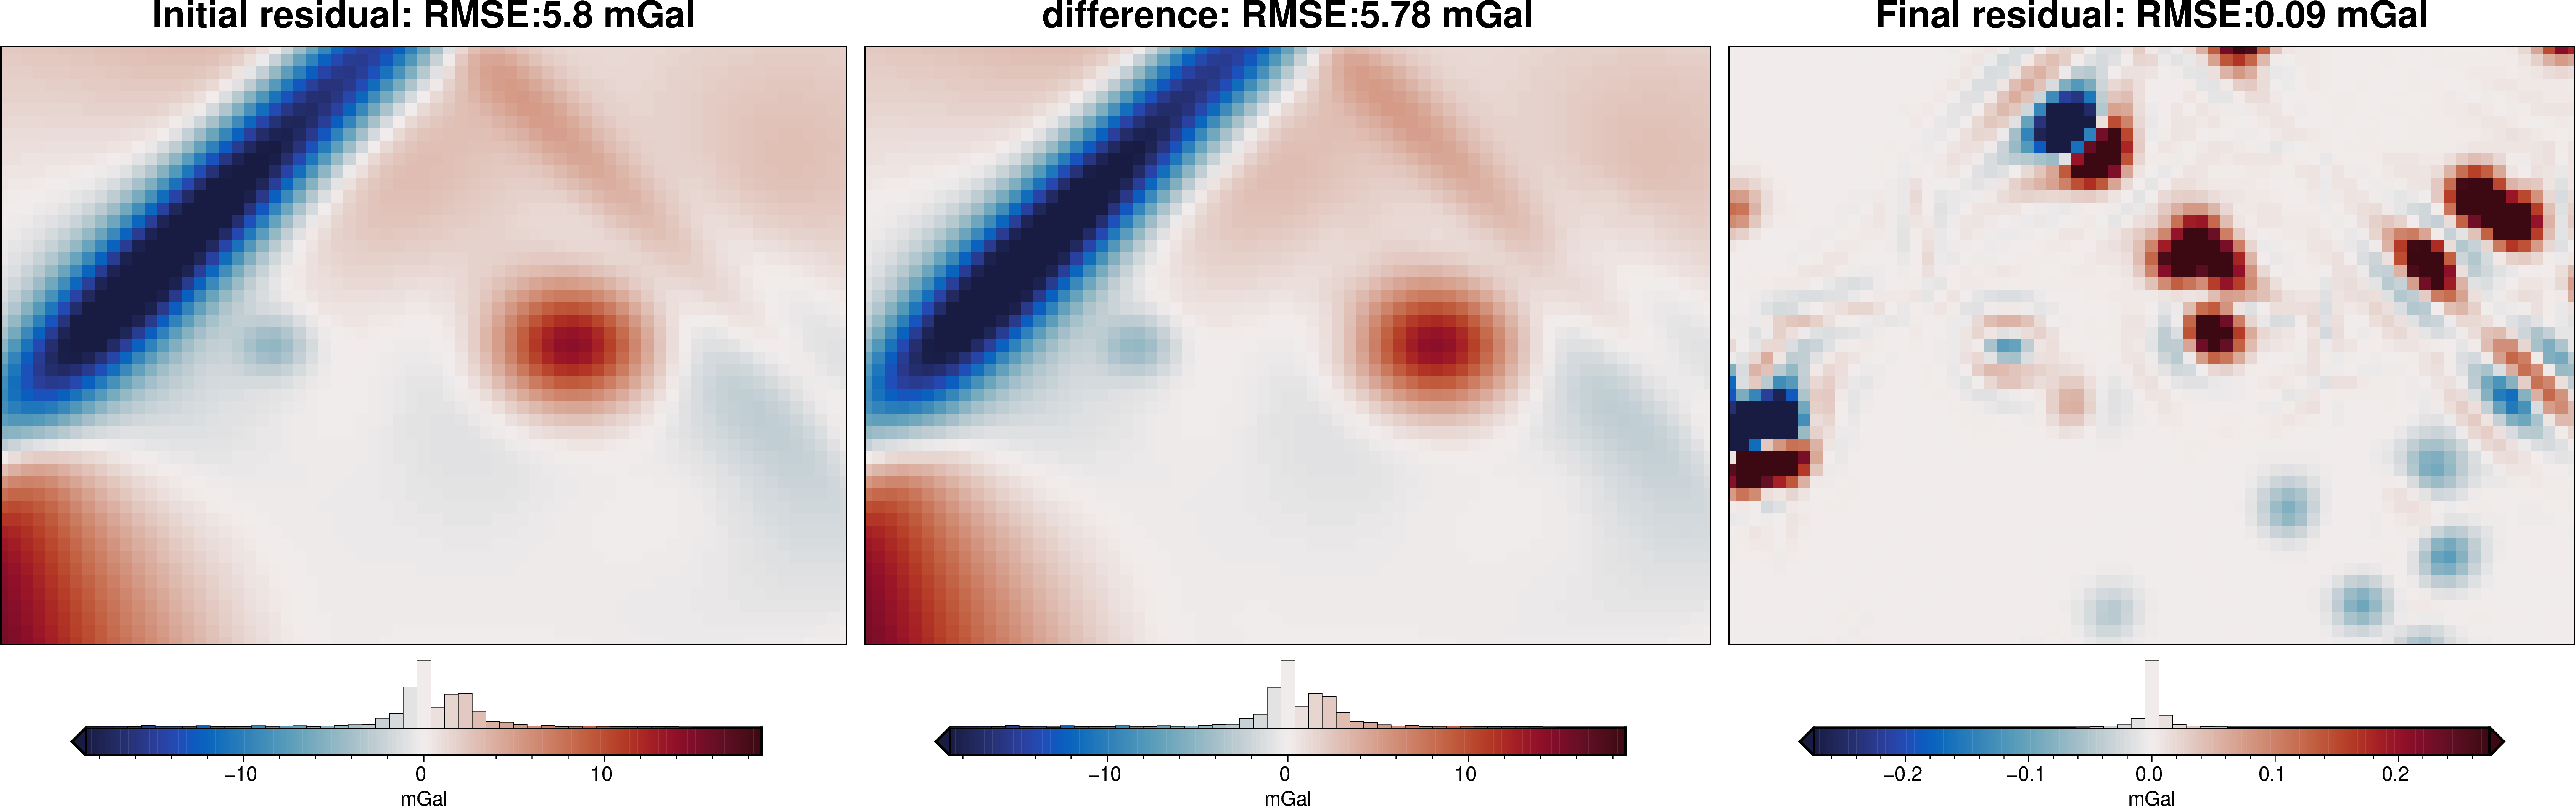

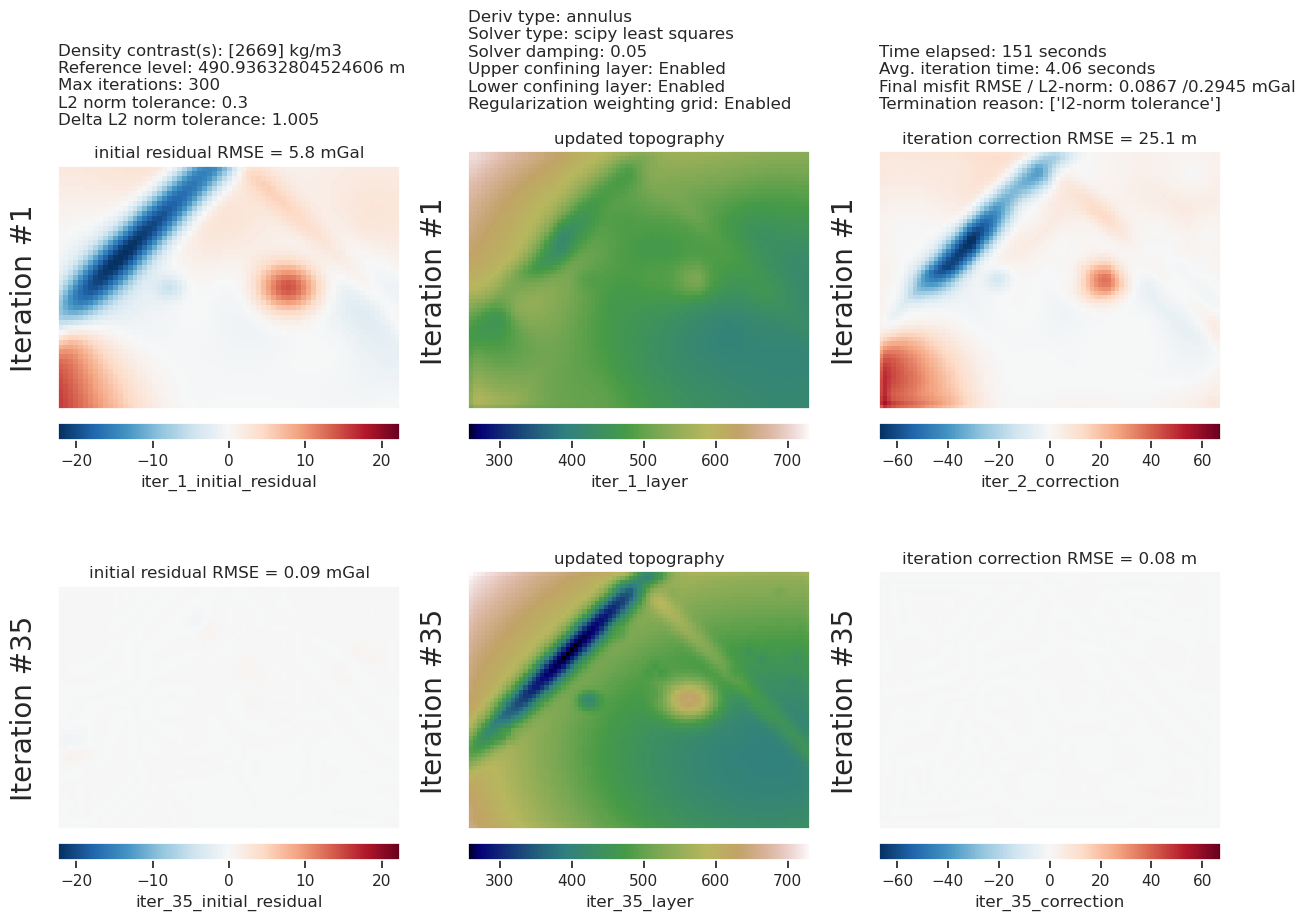

In [24]:
inv.plot_inversion_results(
    iters_to_plot=2,
)

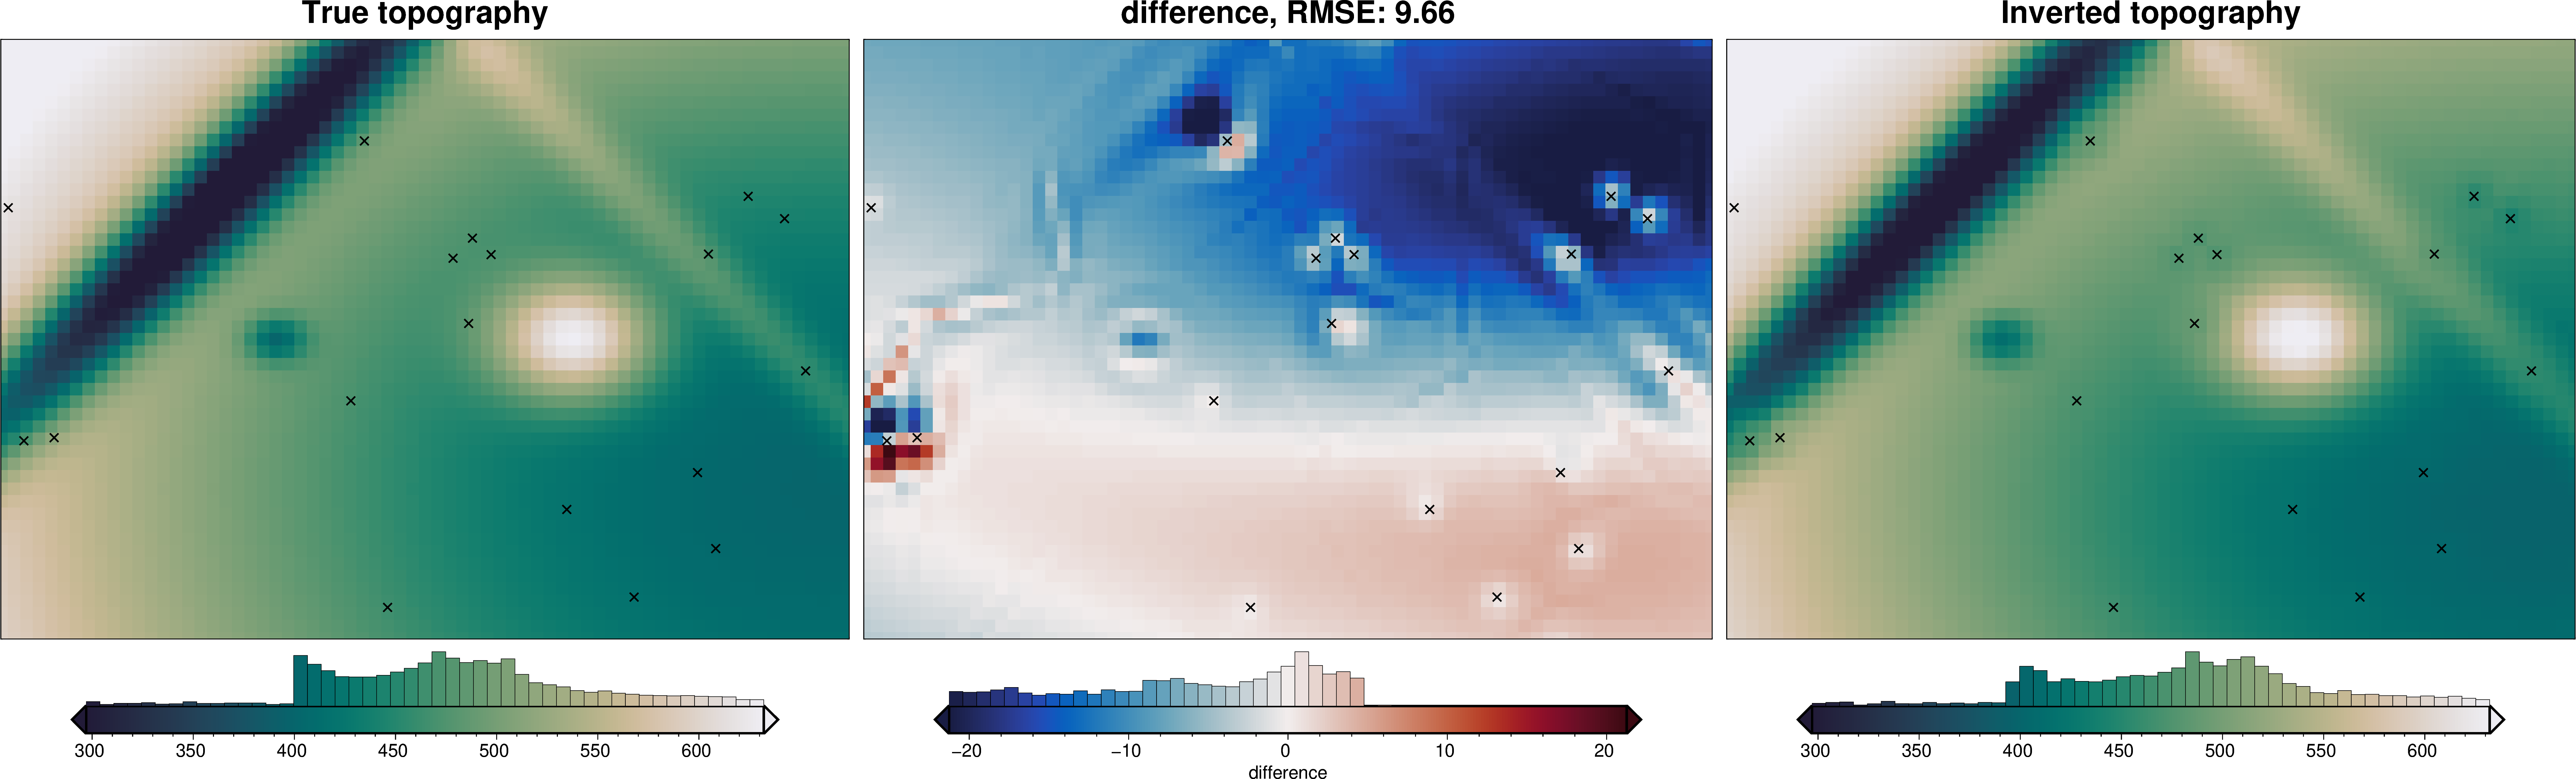

In [ ]:
_ = polar_utils.grd_compare(
    true_topography,
    inv.model.topography,
    region=grav_data.inner_region,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

In [ ]:
# sample the inverted topography at the constraint points
constraint_points = invert4geom.sample_grids(
    constraint_points,
    inv.model.topography,
    "inverted_topography",
)

rmse_with_weighting = invert4geom.rmse(
    constraint_points.upward - constraint_points.inverted_topography
)
max_error_with_weighting = vd.maxabs(
    constraint_points.upward - constraint_points.inverted_topography
)

print(f"RMSE at constraints: {round(rmse_with_weighting, 1)} m")
print(f"max error at constraints: {round(max_error_with_weighting, 1)} m")

RMSE at constraints: 2.1 m
max error at constraints: 4.3 m


## Method 2: Constraint Point Minimization

We can define the regional gravity field so that the residual field, which is the input to the inversion, is already ~0 mGal at constraint points. This means the inversion will minimally alter the topography at theses locations. To do this, we estimate the regional gravity misfit by sampling the values at constraints, and interpolating over the entire region. This defines the regional misfit, which when subtracted from the full misfit, gives the residual misfit. 

### Gravity misfit
Now we need to calculate the forward gravity of the starting topography. We then can subtract it from our observed gravity to get a starting gravity misfit. From this, we estimate the regional field with the values at constraint points.

In [30]:
grav_data.inv.forward_gravity(model)

grav_data.inv.regional_separation(
    method="constraints",
    constraints_df=constraint_points,
)
grav_data

<xarray.Dataset> Size: 475kB
Dimensions:                   (northing: 61, easting: 81)
Coordinates:
  * northing                  (northing) float64 488B 0.0 500.0 ... 3e+04
  * easting                   (easting) float64 648B 0.0 500.0 ... 4e+04
Data variables:
    upward                    (northing, easting) float64 40kB 1.001e+03 ... ...
    upper_surface_grav        (northing, easting) float64 40kB 6.966 ... 2.06
    lower_surface_grav        (northing, easting) float64 40kB -0.04507 ... 0...
    gravity_anomaly           (northing, easting) float64 40kB 6.921 ... 2.445
    forward_gravity           (northing, easting) float64 40kB -2.37 ... 1.78
    misfit                    (northing, easting) float64 40kB 9.291 ... 0.6649
    reg                       (northing, easting) float64 40kB -2.798 ... 0.9961
    res                       (northing, easting) float64 40kB 12.09 ... -0.3312
    starting_forward_gravity  (northing, easting) float64 40kB -2.37 ... 1.78
    starting_misfit           (northing, easting) float64 40kB 9.291 ... 0.6649
    starting_reg              (northing, easting) float64 40kB -2.798 ... 0.9961
    starting_res              (northing, easting) float64 40kB 12.09 ... -0.3312
Attributes:
    region:        (0.0, 40000.0, 0.0, 30000.0)
    spacing:       500.0
    buffer_width:  3000.0
    inner_region:  (3000.0, 37000.0, 3000.0, 27000.0)
    dataset_type:  data
    model_type:    prisms

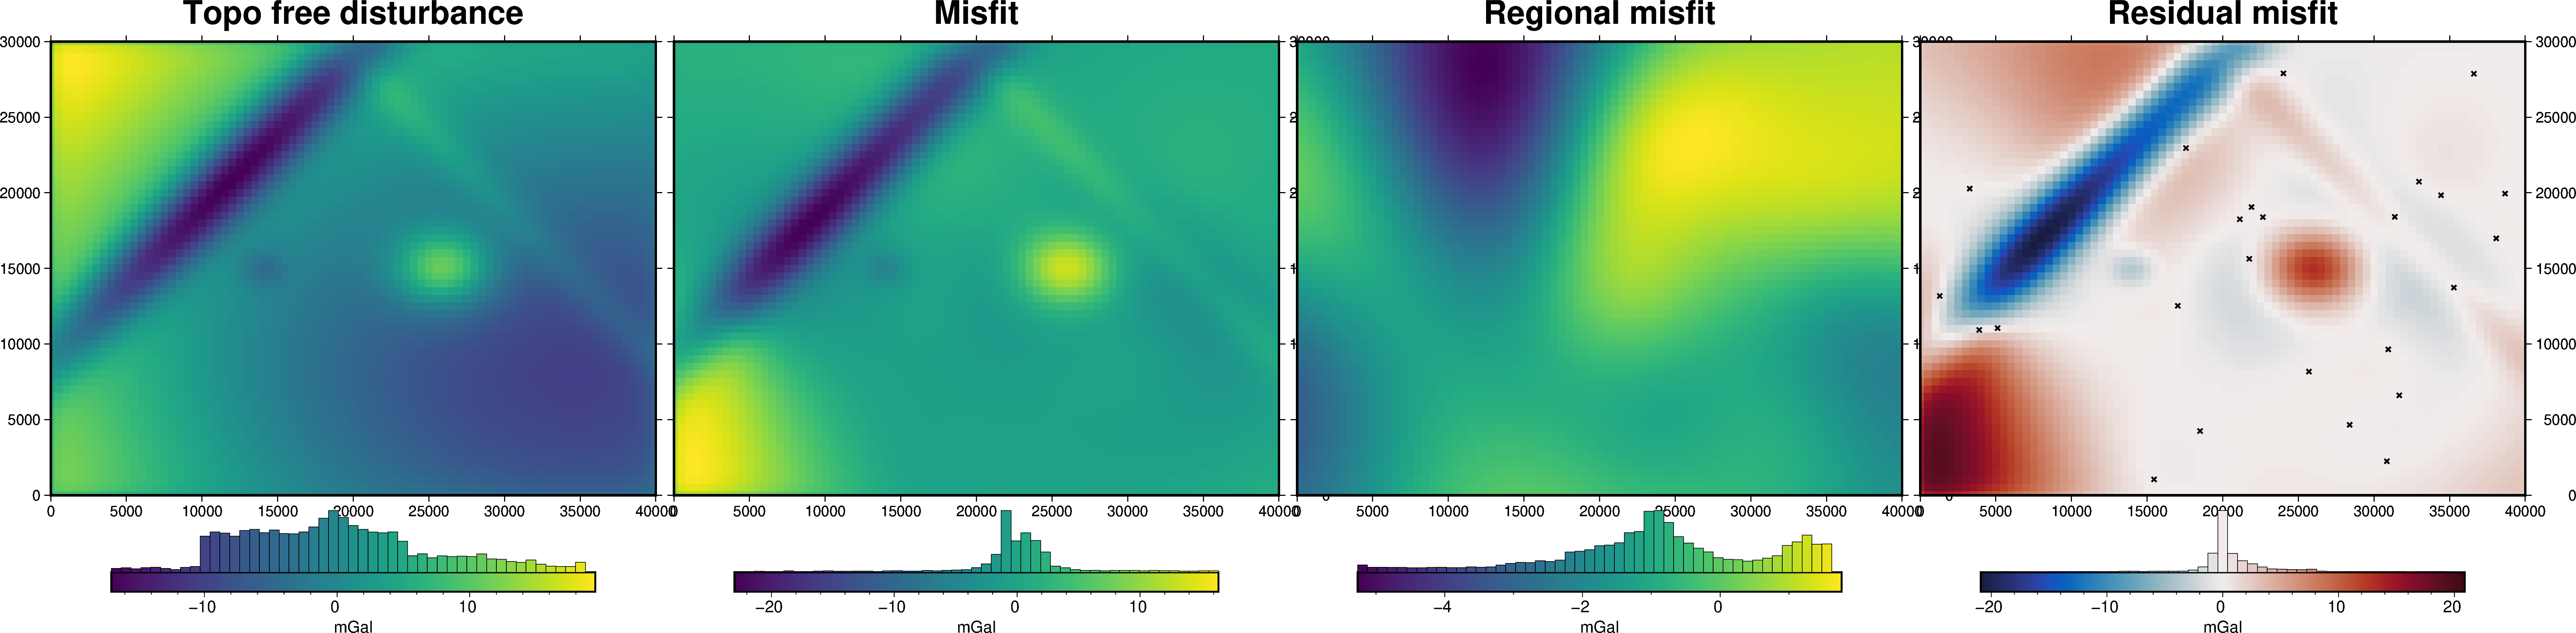

In [31]:
fig = maps.plot_grd(
    grav_data.gravity_anomaly,
    fig_height=10,
    title="Topo free disturbance",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_data.misfit,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Misfit",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_data.reg,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Regional misfit",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_data.res,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Residual misfit",
    cmap="balance+h0",
    cpt_lims=[-vd.maxabs(grav_data.res), vd.maxabs(grav_data.res)],
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
    points=constraint_points,
    points_style="x.15c",
)
fig.show()

### Inversion without weighting grid

In [32]:
# setup the inversion
inv = invert4geom.Inversion(
    grav_data,
    model,
    solver_damping=0.05,
    # set stopping criteria
    max_iterations=300,
    l2_norm_tolerance=0.3,
    delta_l2_norm_tolerance=1.005,
)

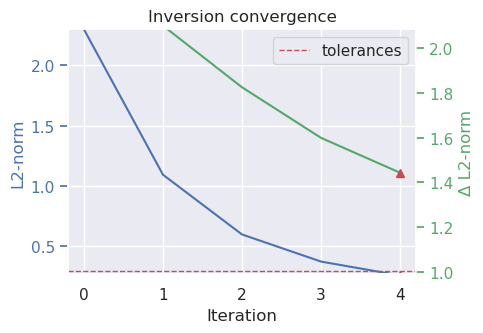

In [33]:
inv.invert(
    plot_dynamic_convergence=True,
    results_fname="../tmp/non_weighted_inversion",
)

In [34]:
inv.stats_df

,iteration,rmse,l2_norm,delta_l2_norm,iter_time_sec
0,0.0,5.277361,2.297251,inf,NaN
1,1.0,1.196444,1.093821,2.100207,3.845974
2,2.0,0.359268,0.599390,1.824892,4.753240
3,3.0,0.140563,0.374918,1.598723,4.729734
4,4.0,0.067529,0.259864,1.442745,4.043527


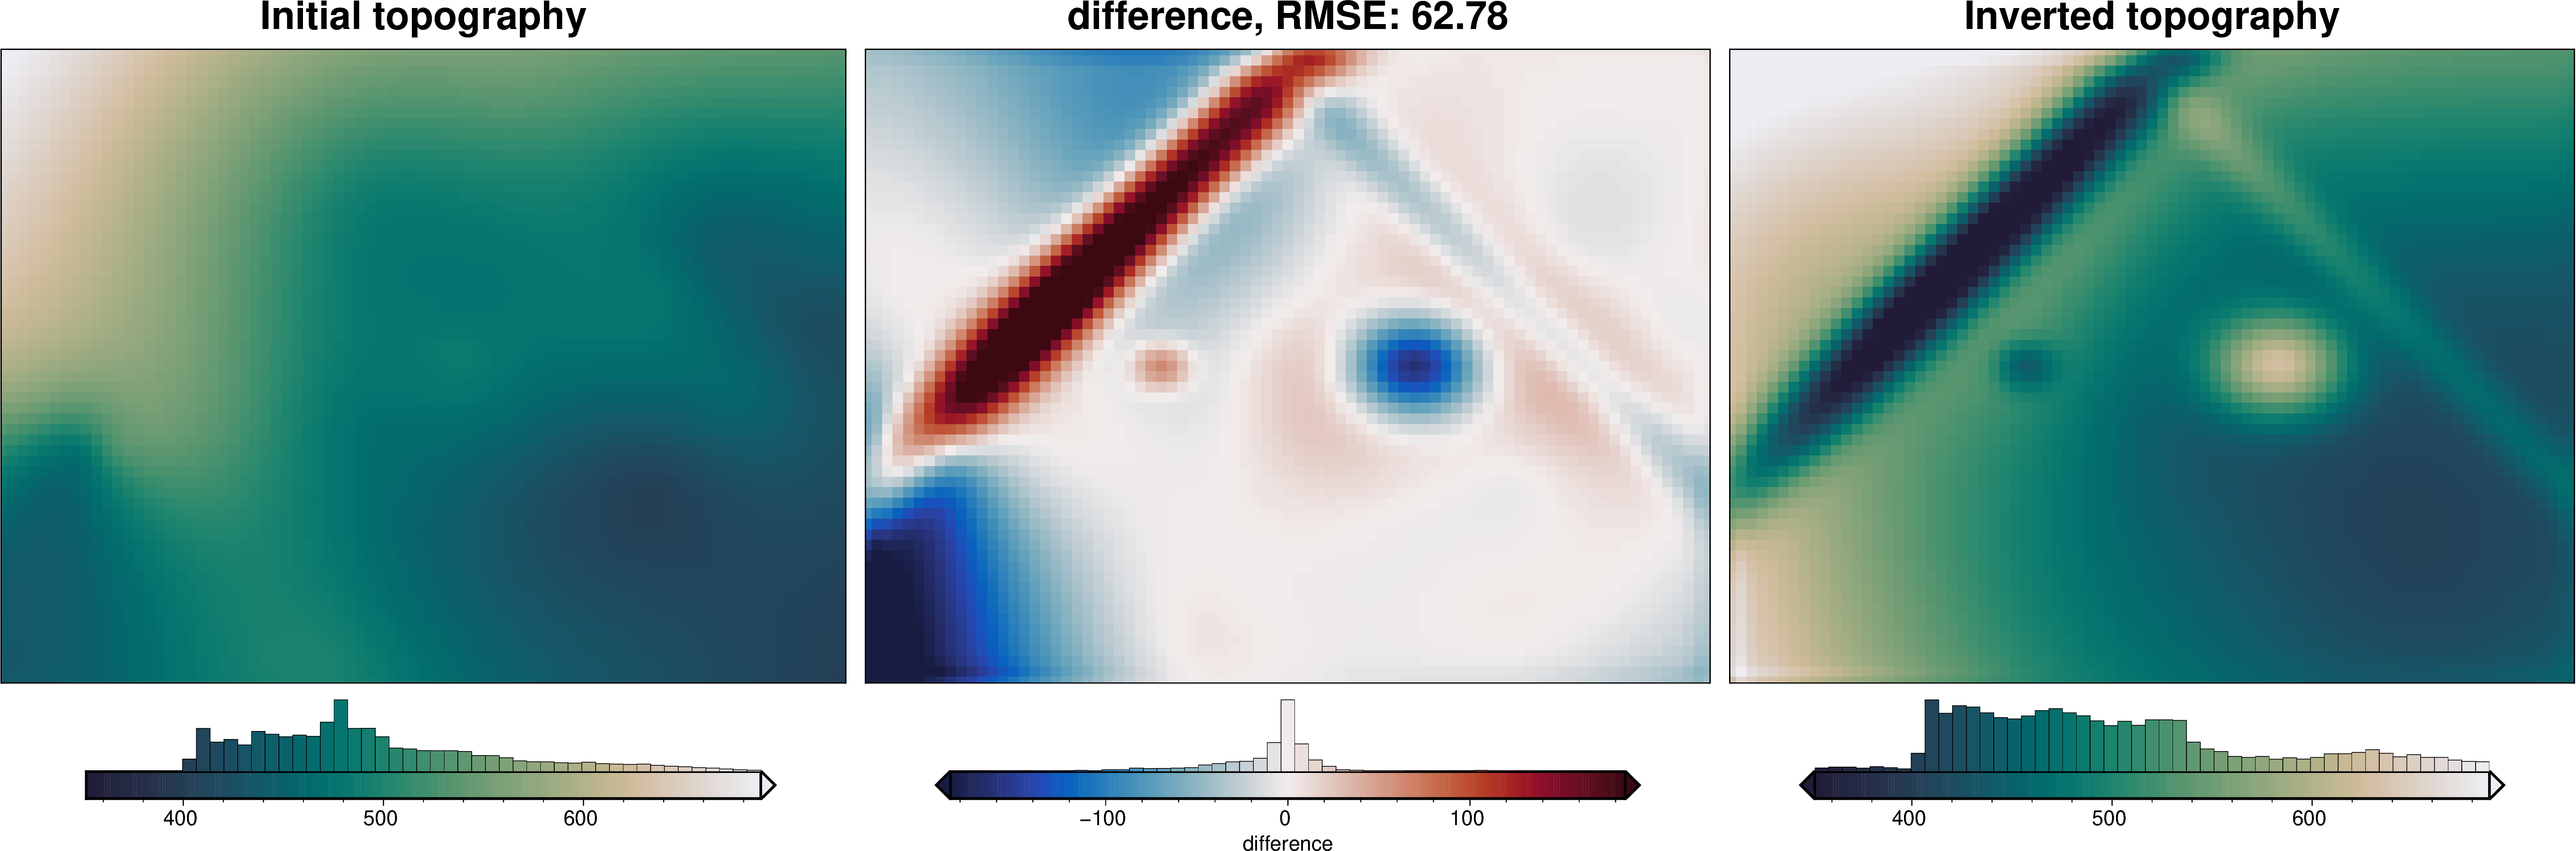

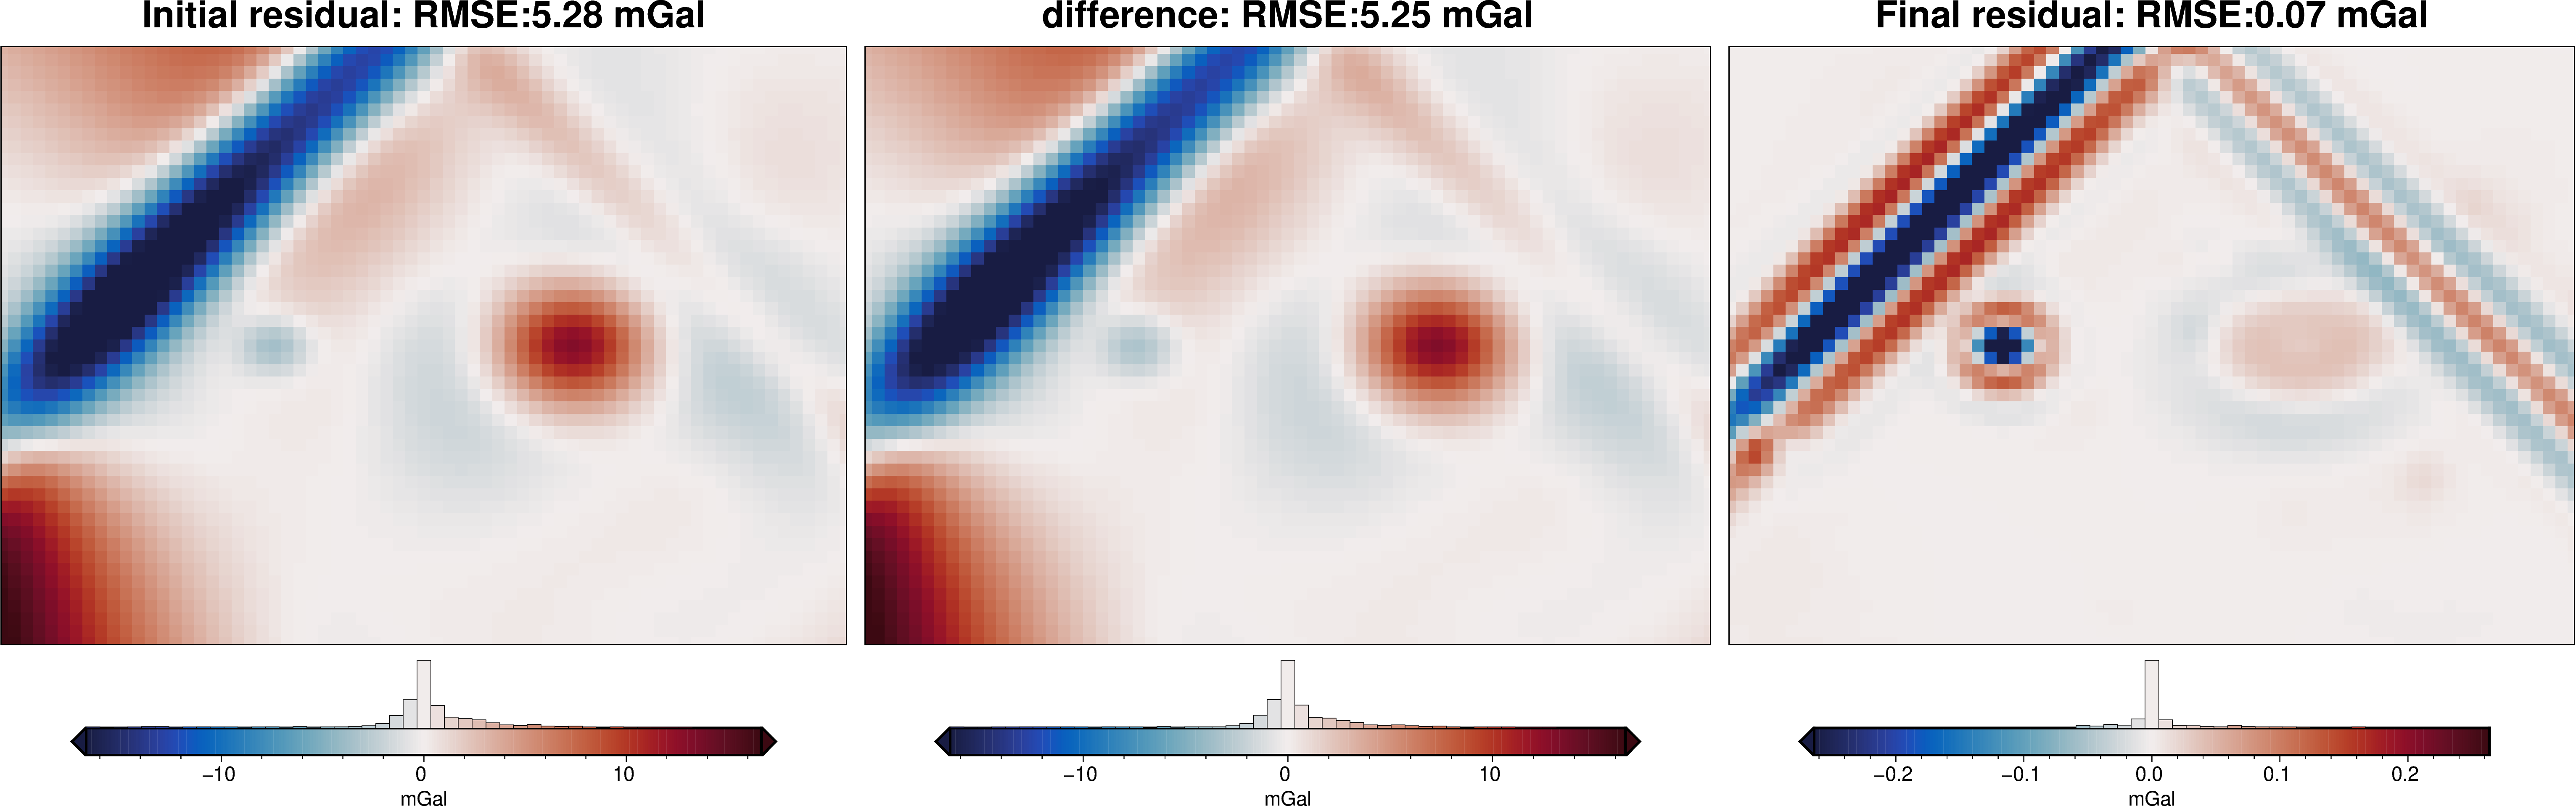

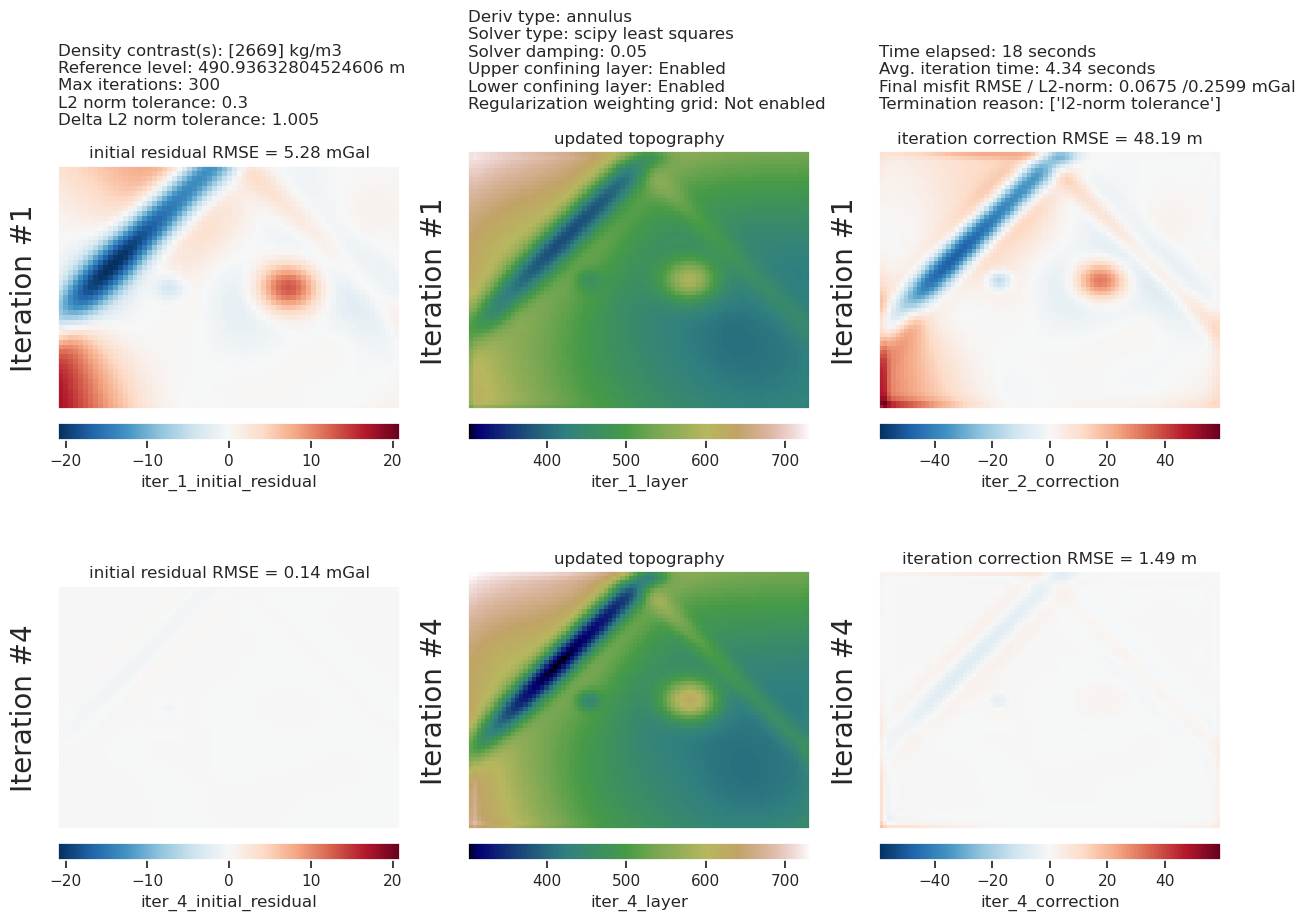

In [35]:
inv.plot_inversion_results(
    iters_to_plot=2,
)

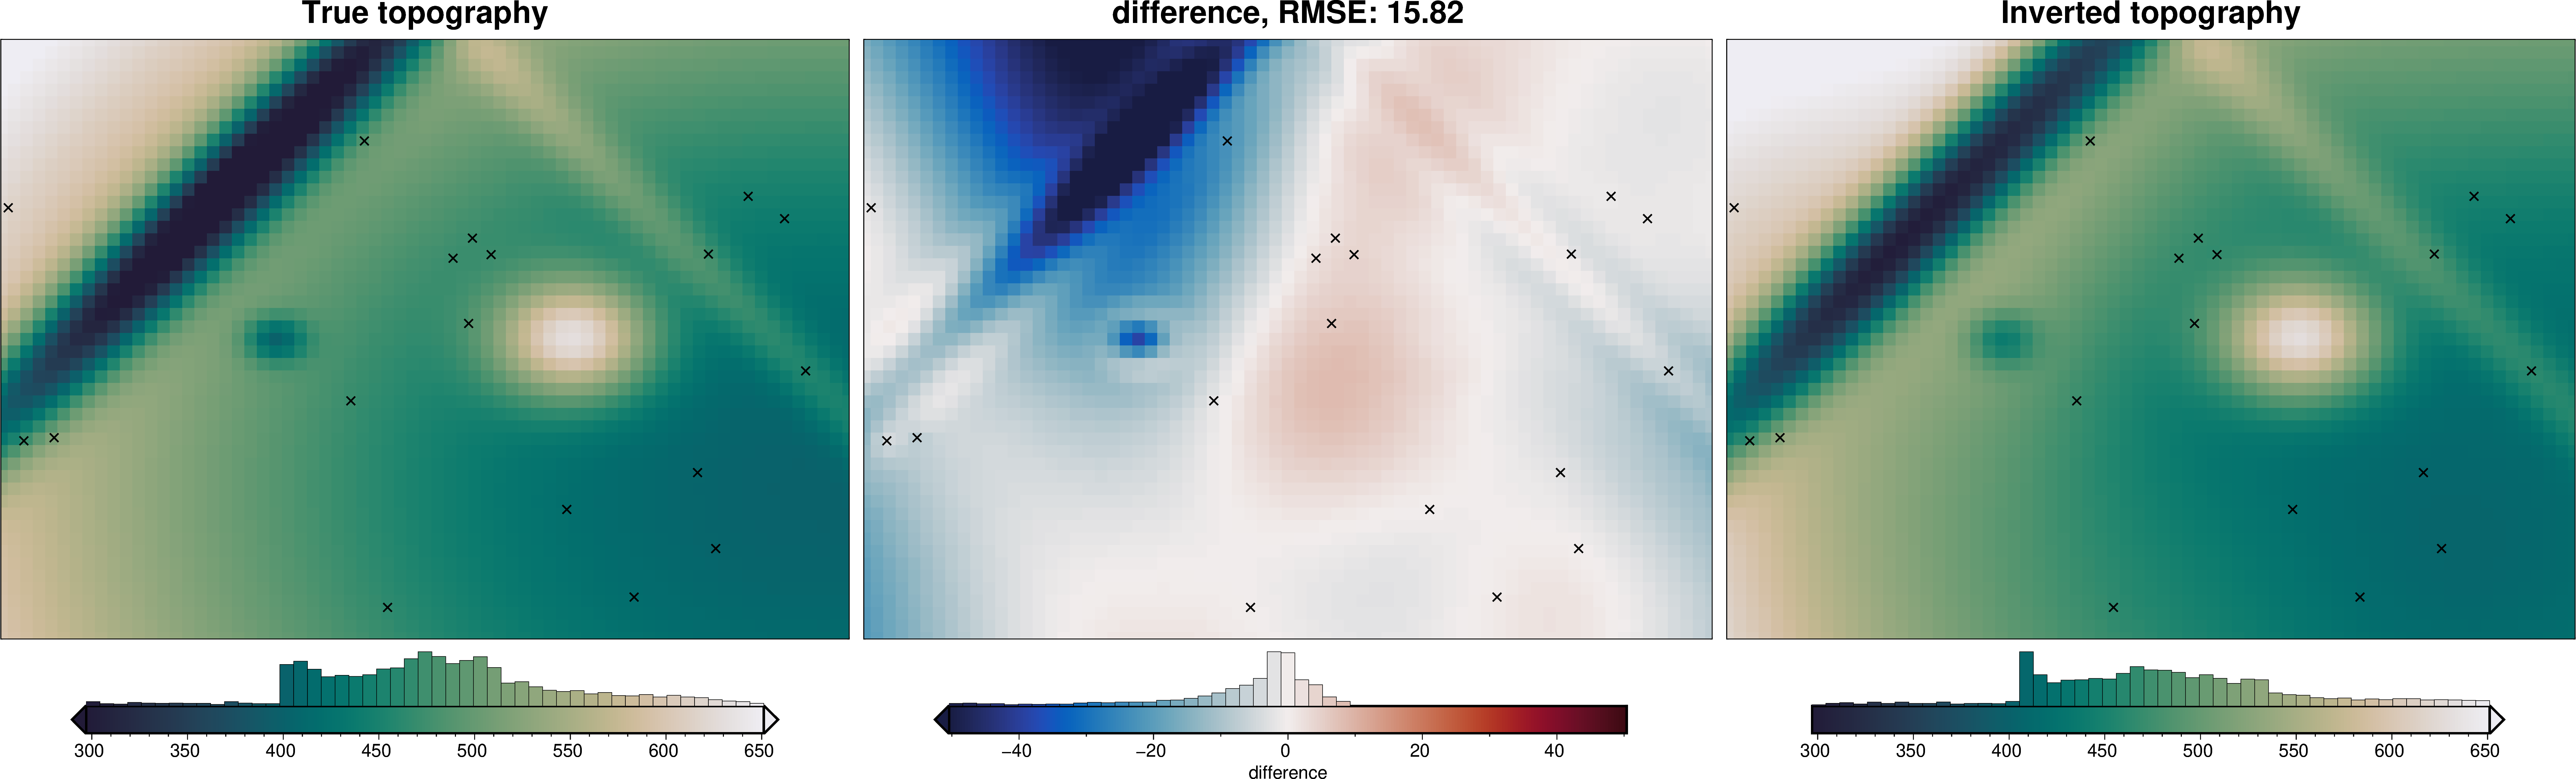

In [ ]:
_ = polar_utils.grd_compare(
    true_topography,
    inv.model.topography,
    region=grav_data.inner_region,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

In [ ]:
# sample the inverted topography at the constraint points
constraint_points = invert4geom.sample_grids(
    constraint_points,
    inv.model.topography,
    "inverted_topography_constraint_point_minimization",
)

rmse_constraint_point_minimization = invert4geom.rmse(
    constraint_points.upward
    - constraint_points.inverted_topography_constraint_point_minimization
)
max_error_constraint_point_minimization = vd.maxabs(
    constraint_points.upward
    - constraint_points.inverted_topography_constraint_point_minimization
)

print(f"RMSE at constraints: {round(rmse_constraint_point_minimization, 1)} m")
print(
    f"max error at constraints: {round(max_error_constraint_point_minimization, 1)} m"
)

RMSE at constraints: 5.6 m
max error at constraints: 22.4 m


#